In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import six

import warnings

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PoissonRegressor
from sklearn.linear_model import TweedieRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import FeatureUnion
from sklearn.metrics import roc_auc_score, log_loss, roc_curve
from sklearn.metrics import precision_recall_curve, confusion_matrix

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

from catboost import CatBoostClassifier
from sklift.models import TwoModels
from sklift.models import ClassTransformation

In [3]:
#pip install catboost

In [4]:
#источник данных: https://www.kaggle.com/davinwijaya/customer-retention
df = pd.read_csv('data.csv', quotechar='\"', 
                 escapechar='\\', 
                 error_bad_lines=False, nrows=20000)

df.columns

Index(['recency', 'history', 'used_discount', 'used_bogo', 'zip_code',
       'is_referral', 'channel', 'offer', 'conversion'],
      dtype='object')

In [5]:
#df.sort_values(by = ["history"]).head(10)

Переименовываем поля (conversion -> target, offer -> treatment):

In [6]:
df = df.rename(columns={"conversion": "target"})
df = df.rename(columns={"offer": "treatment"})

In [7]:
#data["treatment"].unique()
#data.loc[data["treatment"] == "No Offer"]

Приводим поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие:

In [8]:
df.loc[df["treatment"] != "No Offer", "treatment"] = 1
df.loc[df["treatment"] == "No Offer", "treatment"] = 0

In [9]:
#df.set_index(range(len(df)))
df.insert(0, "Index", range(len(df)), True)

In [10]:
df = df.set_index("Index")

In [11]:
df.index = df.index.astype("uint64")

In [12]:
df

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
Index,,,,,,,,,
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0
...,...,...,...,...,...,...,...,...,...
19995,7,426.89,1,0,Surburban,0,Phone,1,0
19996,4,74.59,1,0,Urban,1,Phone,0,0
19997,9,29.99,1,0,Surburban,0,Phone,0,0


In [13]:
print(df['zip_code'].unique())
df.loc[df['zip_code'] == 'Surburban', 'zip_code'] = 1
df.loc[df['zip_code'] == 'Rural', 'zip_code'] = 2
df.loc[df['zip_code'] == 'Urban', 'zip_code'] = 0
print(df['zip_code'].unique())

['Surburban' 'Rural' 'Urban']
[1 2 0]


In [14]:
print(df['channel'].unique())
df.loc[df['channel'] == 'Phone', 'channel'] = 1
df.loc[df['channel'] == 'Web', 'channel'] = 2
df.loc[df['channel'] == 'Multichannel', 'channel'] = 0
print(df['channel'].unique())

['Phone' 'Web' 'Multichannel']
[1 2 0]


In [15]:
#X_train, X_test, y_train, y_test = train_test_split(df.drop('target', 1), 
#                                                    df['target'], random_state=0)

In [16]:
#X_train.head()

In [17]:
df_features = df.copy()
df_features = df_features.drop(['target'], axis=1)

df_train = df.iloc[:, 7:9]

df_test = pd.DataFrame(data={"Index" : range(len(df))})
df_test = df_test.set_index("Index")

indices_train = df_train.index
indices_test = df_test.index
indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=123)

In [18]:
df.loc[df["treatment"] == 0].count()

recency          6670
history          6670
used_discount    6670
used_bogo        6670
zip_code         6670
is_referral      6670
channel          6670
treatment        6670
target           6670
dtype: int64

In [19]:
df_train.groupby("treatment")['target'].describe()
#df_train.head()

,count,mean,std,min,25%,50%,75%,max
treatment,,,,,,,,
0,6670.0,0.108846,0.311469,0.0,0.0,0.0,0.0,1.0
1,13330.0,0.168192,0.374051,0.0,0.0,0.0,0.0,1.0


In [20]:
X_train = df_features.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'target']
treat_train = df_train.loc[indices_learn, 'treatment']

X_val = df_features.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment']

X_train_full = df_features.loc[indices_train, :]
y_train_full = df_train.loc[:, 'target']
treat_train_full = df_train.loc[:, 'treatment']

X_test = df_features.loc[indices_test, :]

In [21]:
cat_features = ['used_discount']

models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

In [22]:
#!pip install scikit-uplift==0.2.0
treat_val.unique()

array([1, 0], dtype=object)

# 1 uplift@10%

### 1.1 Модель с признаком коммуникации

uplift@10%: 0.0234


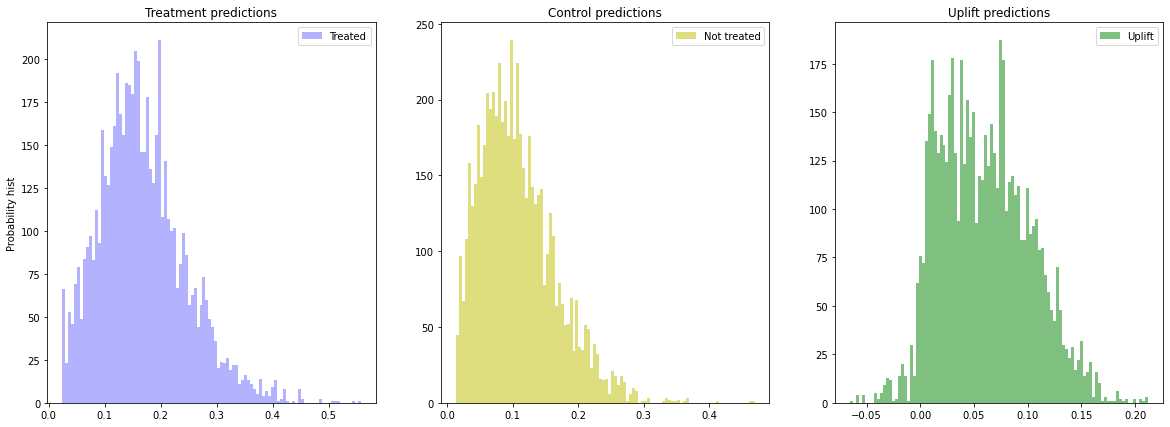

In [23]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
print(f'uplift@10%: {sm_score:.4f}')

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [24]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,recency,16.885509
1,history,15.834297
2,is_referral,14.168749
3,zip_code,12.592658
4,treatment,12.298360
5,channel,11.549983
6,used_bogo,11.127451
7,used_discount,5.542993


### 1.2 Модель с трансформацией таргета

In [25]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score)

<ipython-input-25-3c652d1b76c5>:2: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})


### 1.2 Две независимые модели

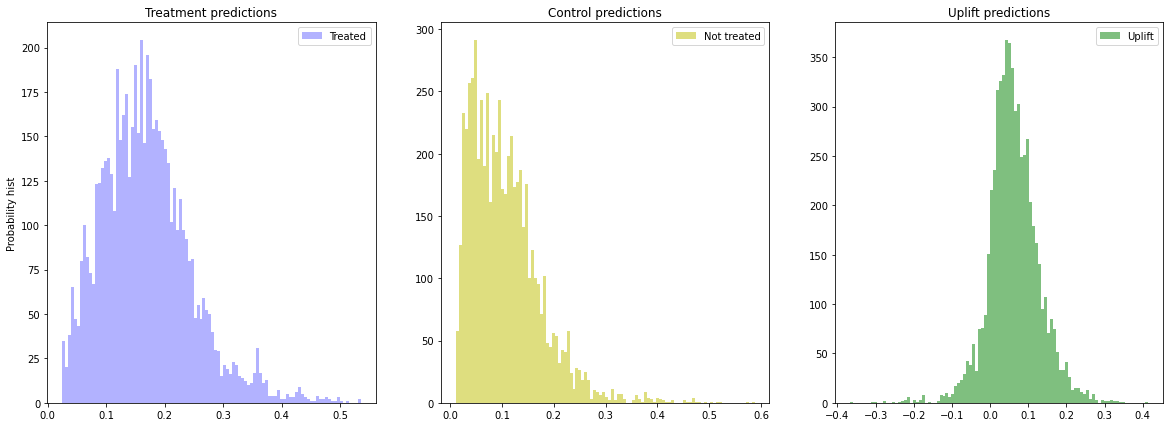

In [26]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

# 2 uplift@20%

### 2.1 Модель с признаком коммуникации

uplift@20%: 0.0319


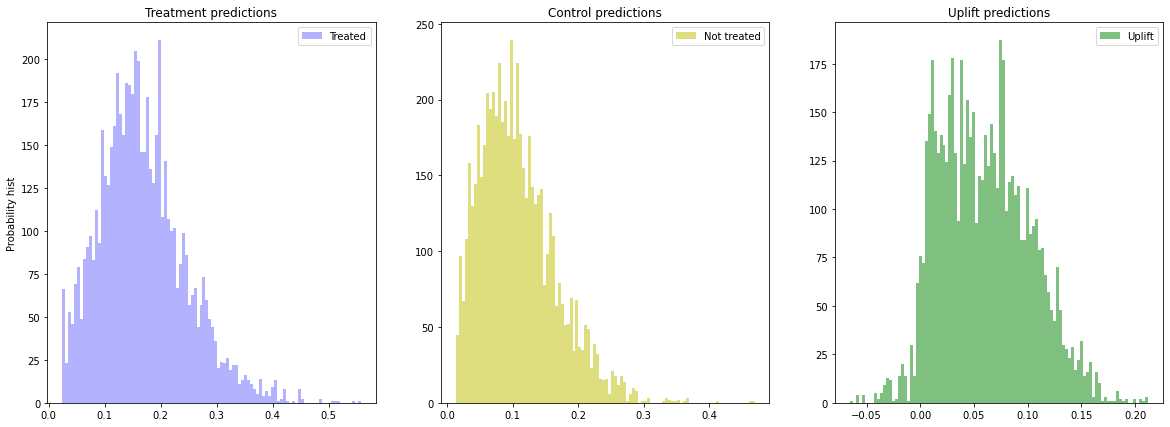

In [27]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)
print(f'uplift@20%: {sm_score:.4f}')

#models_results['approach'].append('SoloModel')
models_results['uplift@20%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

### 2.2 Модель с трансформацией таргета

In [28]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)

#models_results['approach'].append('ClassTransformation')
models_results['uplift@20%'].append(ct_score)

<ipython-input-28-af2cd96527a1>:2: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})


### 2.3 Две независимые модели

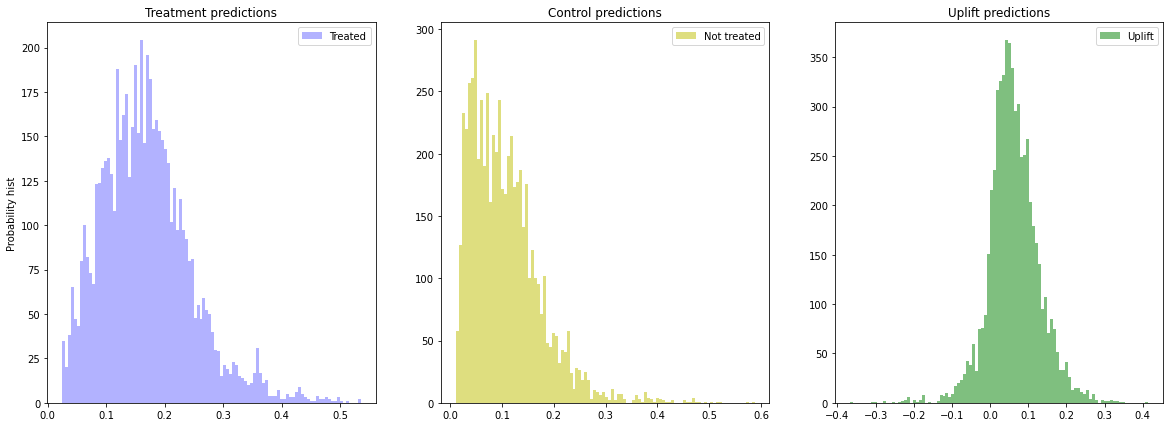

In [29]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)

#models_results['approach'].append('TwoModels')
models_results['uplift@20%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [30]:
pd.DataFrame(data=models_results).sort_values('uplift@20%', ascending=False)
#models_results

,approach,uplift@10%,uplift@20%
1,ClassTransformation,0.161269,0.170883
2,TwoModels,0.053258,0.059119
0,SoloModel,0.023381,0.031912
